# XGBoost regressor 

In [249]:
from pathlib import Path
import warnings
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [2]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
# Seems XGBoost ignores the filter and my attempts to suppress its FutureWarnings!
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [4]:
# Paths to my repo's data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [177]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
# Not necessary when using XGBoost though (try both!)
# df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

# df.info()

#### Separate ERA5 and ERA5-derived features into two dataframes for model training, tuning, and evaluation
- And to allow for quicker selections during experimention

In [178]:
# My 9 weighted ERA5 features
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# My 9 unweighted ERA5 features
unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes including each group
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

-----

## Gradient boosted tree regressor
- Three sets: train, validation, and a hold-out test set
- Go with a rolling window approach using TimeSeriesSplit to cap computational cost of cross-validation
- Documentation on `XGBRegressor` here: https://xgboost.readthedocs.io/en/stable/python/python_api.html

#### Set aside a hold-out test sets for `df_weighted` and `df_unweighted`
- Everything after 2023-01-01 (so I can compare with random forest baseline RMSE score)
    - 'Out of the box' random forest RMSE scores on 2023 test set:
        - `df_unweighted` = 2300
        - `df_weighted` = 2000

In [179]:
# All timestamps after this date are reserved for the 'unseen', hold-out test set!
split_date = '2023-01-01'

# Hold-out sets; the unseen data that I'll use to make predictions using the pre-final and final models
df_hold_out_test_set_weighted = df_weighted.loc[df_weighted.index >= split_date].copy()
df_hold_out_test_set_unweighted = df_unweighted.loc[df_unweighted.index >= split_date].copy()

# Remove my hold-out set from the dataframes
df_weighted = df_weighted.loc[df_weighted.index < split_date].copy()
df_unweighted = df_unweighted.loc[df_unweighted.index < split_date].copy()

#### Set the number of time series splits

In [180]:
n_splits = 5

#### Visualise time series split I want to employ

In [181]:
def plot_time_series_split(df, n_splits=n_splits):
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        # gap=48,
        # Around 1 year and 2 months for each training split
        # max_train_size=10_000,
        # test_size=1_000,
    )

    # Plot the splits
    fig, axes = plt.subplots(n_splits, figsize=(14, 10))

    # Loop through the splits and plot
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]
        
        # plot the target variable (actual power generated)
        ax.plot(y.index[train_index], y.iloc[train_index], 'tab:blue', label='Train')
        ax.plot(y.index[test_index], y.iloc[test_index], 'tab:red', label='Test')
        # set x axis limits
        ax.set_xlim(X.index.min(), X.index.max())
        # plot vertical line denoting where the split takes place
        ax.axvline(
            y.index[train_index][-1], color='black', linestyle='--', linewidth=2, alpha=1
        )

        ax.legend()
        ax.set_title(f'Fold {i}', fontweight='bold')
        ax.set_xlabel('date')
        ax.set_ylabel('Actual MWh')

    plt.tight_layout()
    plt.show()

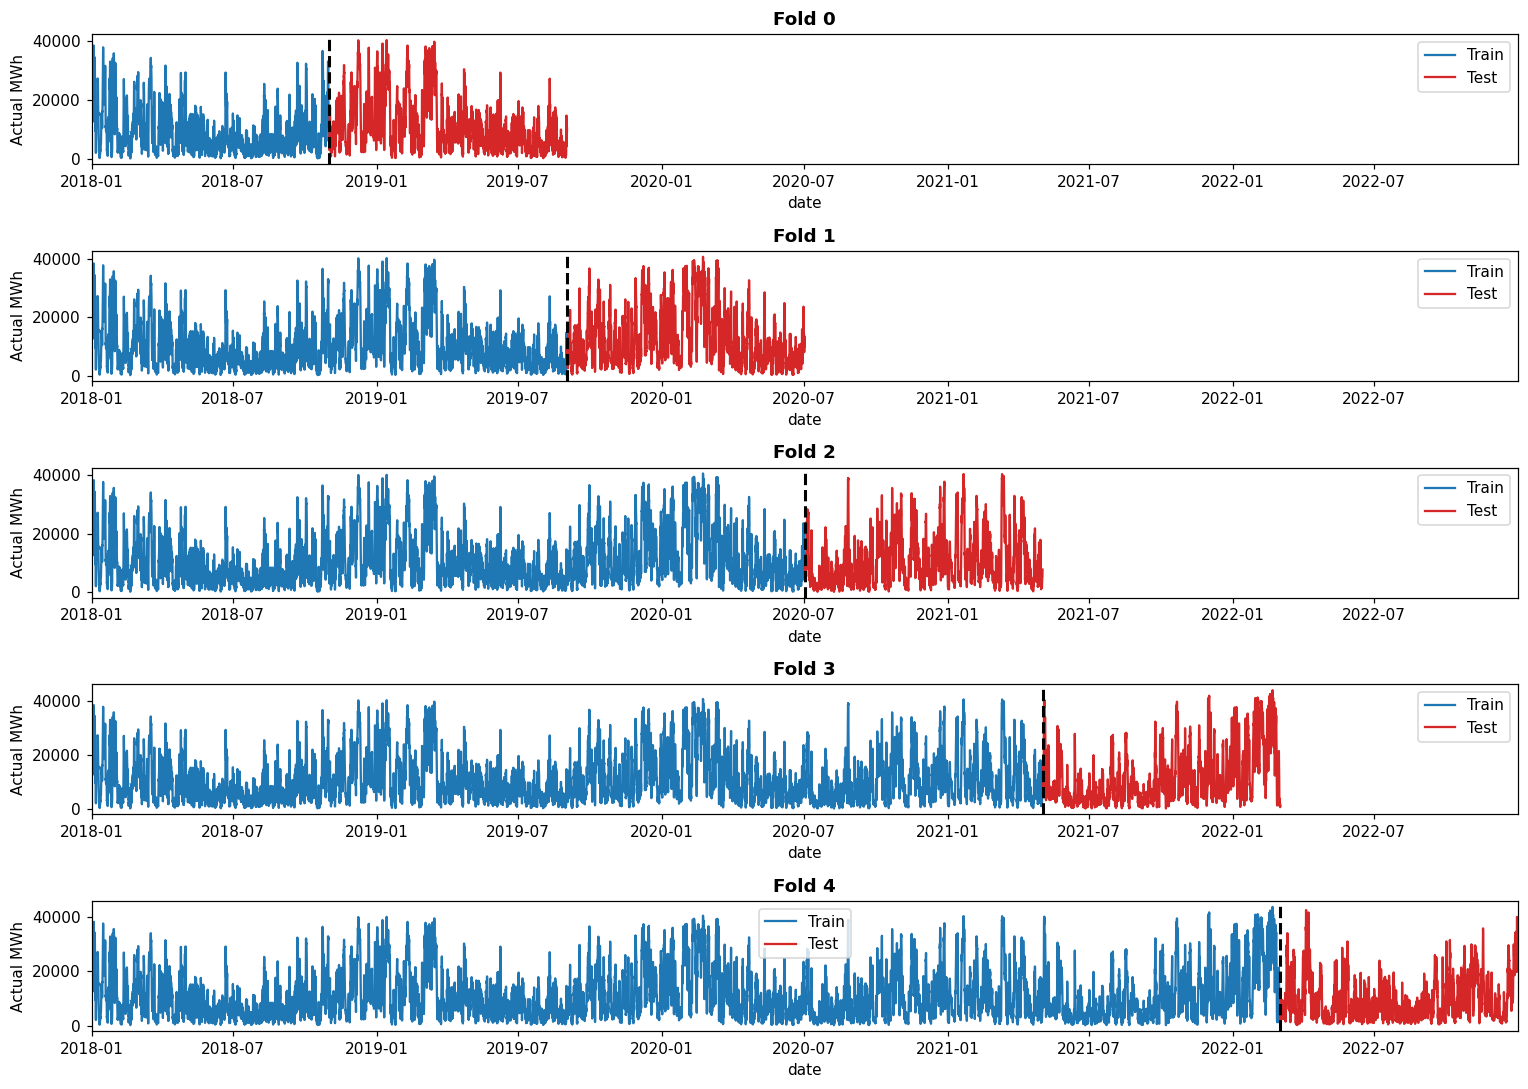

In [182]:
plot_time_series_split(df_unweighted)

-----

## Next steps:
- Step 1: Use TimeSeriesSplit and GridSearchCV to find best model hyperparameters using RMSE as scoring metric
    - Score hold-out test set using this pre-final model
- Step 2: Use best model params to train final model using early stopping to prevent overfitting
    - Score hold-out test set using final model
- Step 3: Plot predictions against actuals and show final RMSE

----

### Step 1
#### Use TimeSeriesSplit and GridSearchCV to find best model hyperparameters using RMSE as scoring metric
- Even a modest param grid with 5 time series splits was pushing 70k fits!
- Switching to RandomizedSearchCV instead

In [183]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

In [184]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [300]:
def find_best_parameters(df, n_splits=n_splits):
    """
    Input is either the unweighted or weighted dataframe (up to end of 2022)
    Output is the fitted GridSearchCV object containing the best model params and other attributes
    """
    # Assign X & y using df; keep datetime as index and select indexes using .iloc
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split object
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        # gap=48,
        # Around 1 year and 2 months for each training split
        # max_train_size=10_000,
        # test_size=1_000,
    )
    
    # Default objective is 'reg:squarederror'
    xgbr = xgb.XGBRegressor(
        # this method is recommended for datasets around 40k+ instances
        tree_method='hist',
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        verbosity=0,
        silent=True,
    )
    
    # Parameters to include in GridSearchCV
    # The below required almost 70k fits!
    # param_grid = {
    #     'n_estimators': [50, 100, 200, 500],
    #     'learning_rate': [0.05, 0.1, 0.2, 0.3],
    #     'max_depth': [3, 4, 5, 6, 7, 8],
    #     'min_child_weight': [1, 5, 10],
    #     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    #     'subsample': [0.7, 0.9],
    #     'gamma': [0, 0.1, 0.2],
    #     'lambda': [0.1, 1],
    # }
    
    # Grid search my params with time series cross-validation
    # grid_search = GridSearchCV(
    #     estimator=xgbr,
    #     param_grid=param_grid,
    #     scoring='neg_root_mean_squared_error',
    #     cv=tscv,
    #     verbose=1,
    #     n_jobs=-1
    # )
    # grid_search.fit(X, y)
    
    # A more extensive param grid for randomised search
    param_grid = {
        # boosted trees/rounds
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 4, 5, 6, 7, 8],
        # max number of bins per feature (since I'm using a histogram tree method); 256 is the default?
        'max_bin': [128, 256, 512, 1024],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bynode': [0.6, 0.7, 0.8, 0.9, 1.0],
        
        # ----- regularisation params to help prevent overfitting ------- 
        # L1 regularisation on weights
        'reg_alpha': [0.1, 1, 2, 5],
        # L2 regularisation on weights
        'reg_lambda': [0.1, 1, 2, 5],
        # regularisation on tree splits (0 = no regularisation)
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    }
    
    # Random search my params with time series cross-validation
    random_search = RandomizedSearchCV(
        estimator=xgbr,
        param_distributions=param_grid,
        # num of param combinations to sample from grid
        n_iter=50,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1,
        random_state=10,
    )

    random_search.fit(X, y)
      
    return random_search

In [266]:
# start timer
start_time = time.time()

# execute my custom random search function for both dataframes
random_search_unweighted = find_best_parameters(df_unweighted)
random_search_weighted = find_best_parameters(df_weighted)

# end timer
end_time = time.time()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

In [267]:
print(f"Time taken to find best parameters performing {2*(len(random_search_unweighted.cv_results_['mean_fit_time']) * n_splits)} fits: {end_time - start_time:.2f} seconds")
print('----------')
print(f'Best parameters found for df_unweighted: {random_search_unweighted.best_params_}')
print(f'Lowest mean RMSE found for for df_unweighted: {-random_search_unweighted.best_score_}')
print('----------')
print(f'Best parameters found for df_weighted: {random_search_weighted.best_params_}')
print(f'Lowest mean RMSE found for df_weighted: {-random_search_weighted.best_score_}')

Time taken to find best parameters performing 300 fits: 117.01 seconds
----------
Best parameters found for df_unweighted: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'max_bin': 128, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8}
Lowest mean RMSE found for for df_unweighted: 1492.3783312215114
----------
Best parameters found for df_weighted: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 8, 'max_bin': 512, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'colsample_bylevel': 1.0}
Lowest mean RMSE found for df_weighted: 1393.184066550274


In [268]:
print(random_search_unweighted.best_score_)
print(random_search_weighted.best_score_)

-1492.3783312215114
-1393.184066550274


In [269]:
print(random_search_unweighted.best_index_)
print(random_search_weighted.best_index_)

0
8


In [271]:
print(random_search_unweighted.best_params_)
print('-----')
print(random_search_weighted.best_params_)

{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'max_bin': 128, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8}
-----
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 8, 'max_bin': 512, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'colsample_bylevel': 1.0}


#### Read results into pandas dataframe for easier inspection
- Quick inspection to verify that all time splits have been scored!

In [289]:
df_cv_results_unweighted = pd.DataFrame(random_search_unweighted.cv_results_)
df_cv_results_weighted = pd.DataFrame(random_search_weighted.cv_results_)

df_cv_results = df_cv_results_unweighted.merge(
    df_cv_results_weighted,
    how='inner',
    left_index=True, 
    right_index=True, 
    suffixes=(None, '_weighted')
)
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mean_fit_time                     30 non-null     float64
 1   std_fit_time                      30 non-null     float64
 2   mean_score_time                   30 non-null     float64
 3   std_score_time                    30 non-null     float64
 4   param_subsample                   30 non-null     object 
 5   param_reg_lambda                  30 non-null     object 
 6   param_reg_alpha                   30 non-null     object 
 7   param_n_estimators                30 non-null     object 
 8   param_min_child_weight            30 non-null     object 
 9   param_max_depth                   30 non-null     object 
 10  param_max_bin                     30 non-null     object 
 11  param_learning_rate               30 non-null     object 
 12  param_gamm

In [290]:
df_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.246781      0.683469         0.109073        0.003697   
1        0.694606      0.263078         0.043580        0.003606   
2        6.609829      1.968523         0.346394        0.003056   
3        0.719347      0.249576         0.039372        0.003613   
4        2.651463      0.967521         0.156604        0.004068   
5        2.569725      0.660329         0.046555        0.005720   
6        1.289853      0.338417         0.043192        0.003196   
7        0.885090      0.277238         0.033870        0.002399   
8       23.141051      5.115021         0.394028        0.013809   
9        6.578403      1.505311         0.268495        0.017014   
10       1.037137      0.356953         0.052216        0.004362   
11       4.970422      1.271249         0.153788        0.007434   
12       7.058522      1.915893         0.270737        0.007976   
13       1.465024      0.442351         0.064454        0.003203   
14       1.421633      0.467301         0.065396        0.002651   
15       4.711243      1.162833         0.197342        0.024136   
16       1.707392      0.391500         0.049628        0.004569   
17       3.740336      0.668985         0.076397        0.001405   
18       4.357697      1.147376         0.212166        0.004771   
19       0.415639      0.163308         0.028195        0.004596   
20       0.613013      0.186800         0.032055        0.001760   
21      14.296414      2.394653         0.235467        0.065933   
22       2.551791      0.534532         0.068159        0.001909   
23       1.979812      0.643387         0.064188        0.002960   
24       3.305657      0.913247         0.105023        0.005089   
25       9.234233      1.655809         0.187729        0.087282   
26       0.494693      0.189145         0.031296        0.001087   
27       2.046936      0.556350         0.051568        0.004085   
28       2.178468      0.339211         0.089623        0.025218   
29       0.615978      0.204165         0.029136        0.004995   

   param_subsample param_reg_lambda param_reg_alpha param_n_estimators  \
0              0.8                2               1                200   
1              0.9                2               1                100   
2              0.6              0.1             0.1                500   
3              0.9                2               1                100   
4              1.0              0.1               1                500   
5              1.0                1             0.1                 50   
6              1.0              0.1               5                 50   
7              0.7                1               1                100   
8              0.8                2               1                500   
9              0.8                2               2                500   
10             1.0                5               5                200   
11             0.7                1             0.1                500   
12             0.6              0.1               2                500   
13             0.7                2             0.1                200   
14             0.7                1               1                200   
15             0.6              0.1               2                200   
16             0.7                5               1                 50   
17             0.7                1               2                200   
18             0.6                1               5                500   
19             0.7                2               2                 50   
20             1.0                2               2                 50   
21             0.7              0.1               1                500   
22             0.7              0.1               5                100   
23             0.6                5               1                100   
24             0.7                1          

#### Make predictions and score hold-out test set
- Intermediate check to see if early stopping can improve on this RMSE score!
- RF on unweighted was 2300. A score of 1700 is a 25% decrease in error!

In [292]:
def score_hold_out(estimator, df):
    """
    Input df is the hold-out test set
    """
    X_test = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y_test = df['actual_generated_smard_mwh'].copy()

    # make target predictions using test set
    y_preds = estimator.predict(X_test)
    # calculate RMSE error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE of model predictions on hold-out set: {rmse:.2f}')

In [294]:
score_hold_out(random_search_weighted.best_estimator_, df_hold_out_test_set_weighted)

RMSE of model predictions on hold-out set: 1664.22


In [291]:
random_search_weighted.best_params_

{'subsample': 0.8,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 8,
 'max_bin': 512,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 1.0}

-----

### Step 2
#### Now use best params to train final model all data up to 2023 using early stopping to prevent overfitting

In [296]:
def train_final_model_early_stopping(df, random_search):
    """
    Input is either the weighted or unweighted dataframe (up to end of 2022)
    and the fitted GridSearchCV object
    Output is the fitted XGB model using best model params and early stopping
    """
    # Split using c. 80% of timestamps for train set and the rest for test (round to nearest thousand)
    train_length = int(round(len(df) * 0.8, -3))
    test_length = len(df) - train_length

    # Train sets for X & y - used to fit new model using best params from GridSearchCV
    X_train = df.iloc[:train_length].drop(columns=['actual_generated_smard_mwh']).copy()
    y_train = df.iloc[:train_length]['actual_generated_smard_mwh'].copy()

    # Validation sets for X & y
    # Validation length around one full year (all of 2022)
    X_val = df.iloc[-test_length:].drop(columns=['actual_generated_smard_mwh']).copy()
    y_val = df.iloc[-test_length:]['actual_generated_smard_mwh'].copy()

    # Use best model parameters from GridSearchCV
    best_params = random_search.best_params_
    xgbr_final = xgb.XGBRegressor(
        tree_method='hist',
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        # Stop if no RMSE improvement in eval set after a number of trees/rounds
        early_stopping_rounds=40,
        **best_params,
    )

    # Evaluate train and validation sets to score and trigger early stopping and prevent overfitting
    # Early stopping triggered by validation set (validation_1) 
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgbr_final.fit(
        X_train,
        y_train, 
        # eval_metric='rmse',
        eval_set=eval_set,
        verbose=True,
    )
    return xgbr_final

#### Note how RMSE on train set continue to improve while validation set gets worse
- Hence why early stopping helps to prevent overfitting!

In [297]:
xgbr_final = train_final_model_early_stopping(df_weighted, random_search_weighted)

[0]	validation_0-rmse:12511.70299	validation_1-rmse:13639.72994
[1]	validation_0-rmse:11283.46245	validation_1-rmse:12378.92680
[2]	validation_0-rmse:10178.80695	validation_1-rmse:11247.67760
[3]	validation_0-rmse:9186.17882	validation_1-rmse:10225.45332
[4]	validation_0-rmse:8294.83462	validation_1-rmse:9308.92864
[5]	validation_0-rmse:7494.21701	validation_1-rmse:8483.41521
[6]	validation_0-rmse:6774.69792	validation_1-rmse:7743.01336
[7]	validation_0-rmse:6129.35263	validation_1-rmse:7069.65100
[8]	validation_0-rmse:5550.83812	validation_1-rmse:6464.70331
[9]	validation_0-rmse:5031.61360	validation_1-rmse:5922.47439
[10]	validation_0-rmse:4571.06265	validation_1-rmse:5456.30910
[11]	validation_0-rmse:4154.33858	validation_1-rmse:5026.64458
[12]	validation_0-rmse:3780.42186	validation_1-rmse:4631.02997
[13]	validation_0-rmse:3447.47521	validation_1-rmse:4279.13239
[14]	validation_0-rmse:3148.79068	validation_1-rmse:3965.02925
[15]	validation_0-rmse:2883.30051	validation_1-rmse:3679.1

#### Best boosting round and its RMSE score (triggered by early stopping)

In [298]:
print(xgbr_final.best_iteration)
print(xgbr_final.best_score)

292
1378.8356600881616


##### Use final model to make predictions for the first half of 2023 using the hold-out test set 
- I have not used this hold-out set yet, thereby simulating 'unseen' data 
- Did early stopping improve the RMSE?

#### Final model RMSE on hold-out set

In [299]:
score_hold_out(xgbr_final, df_hold_out_test_set_weighted)

RMSE of model predictions on hold-out set: 1729.96


Best scores seen so far:
- Early stopping: ~1559~ ~1504~ ~1471~ 1378
- Hold-out test set: ~1843~ ~1787~ ~1776~ 1729

- Best params so far:

```
{'subsample': 0.8,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 8,
 'max_bin': 512,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 1.0}
```

----

### Step 3
#### Plot predictions against actuals and show final RMSE